# Project 5 - Part A
### Image Warping and Mosaicing
Romil Bhardwaj

In [42]:
import csv
import math
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.linalg import LinAlgError
from scipy.spatial.qhull import Delaunay
from skimage.draw import draw
from skimage.transform import rescale, resize, downscale_local_mean
import os
import glob
import random

### Methods to read images and annotated kyepoints

In [2]:
def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path, target_res=None):
    img = skio.imread(img_path)

    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}.csv')

    keypoints = read_keypoints(csv_path)
    if target_res:
        target_x, target_y = target_res
        current_x, current_y, _ = img.shape
        x_rescale = target_x/current_x
        y_rescale = target_y/current_y
        # Resize image:
        img = resize(img, (target_y, target_x), anti_aliasing=True)
        # Resize keypoints:
        keypoints[:,0] *= x_rescale
        keypoints[:,1] *= y_rescale
    return img, keypoints

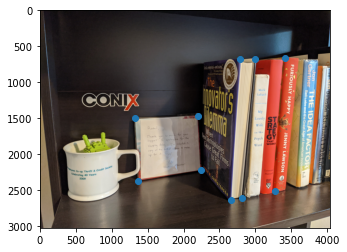

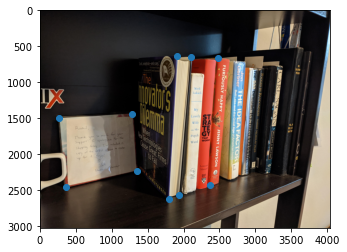

In [3]:
# Test iamge reading and keypoints
img1, kps1 = read_img_and_keypoints('imgs/shelf1.jpg')

plt.imshow(img1)
plt.scatter(x=kps1[:,0], y=kps1[:,1])
plt.savefig('outputs/annotated_eg1.jpg', bbox_inches='tight')

plt.figure()
img2, kps2 = read_img_and_keypoints('imgs/shelf2.jpg')
plt.imshow(img2)
plt.scatter(x=kps2[:,0], y=kps2[:,1])
plt.savefig('outputs/annotated_eg2.jpg', bbox_inches='tight')

## Define homography methods



In [18]:
def pdm(p1, p2):
    top = np.array([-p2[0], -p2[1], -1, 0, 0, 0, p2[0]*p1[0], p2[1]*p1[0]])
    bottom = np.array([0, 0, 0, -p2[0], -p2[1], -1, p2[0]*p1[1], p2[1]*p1[1]])
    return np.vstack([top, bottom])

def fillb(pts):
    num_pts = pts.shape[0]
    b = np.zeros((num_pts*2, 1))
    i = 0
    for i in range(num_pts):
        b[i*2] = - pts[i][0]
        b[i*2+1] = - pts[i][1]
    return b

def compute_homography(pts1, pts2):
    assert pts1.shape[0] == pts2.shape[0]
    num_pts = pts1.shape[0]
    b = fillb(pts1)
    A = pdm(pts1[0,:], pts2[0,:])

    for i in range(1, num_pts):
        newline = pdm(pts1[i, :], pts2[i, :])
        A = np.vstack([A, newline])

    H_arr = (np.linalg.lstsq(A, b, rcond=-1)[0]).T[0]
    H = np.matrix([[H_arr[0], H_arr[1], H_arr[2]],
                  [H_arr[3], H_arr[4], H_arr[5]],
                   [H_arr[6], H_arr[7], 1.]])
    return H

In [20]:
H = compute_homography(kps1, kps2)

In [43]:
def check_bounding_box(target_shape, H):
    max_x = target_shape[1]
    max_y = target_shape[0]

    lower_left = [[0], [max_y], [1]]
    lower_right = [[max_x], [max_y], [1]]
    upper_left = [[0], [0], [1]]
    upper_right = [[max_x], [0], [1]]

    new_bounds_list = [lower_left, lower_right,
                       upper_left, upper_right]


    new_bounds_list = [H * point for point in new_bounds_list]
    new_bounds_list = [point / point[2] for point in new_bounds_list]
    new_max_x = max(new_bounds_list, key=lambda x: x[0])[0].astype(np.int)
    new_max_y = max(new_bounds_list, key=lambda x: x[1])[1].astype(np.int)
    new_min_x = min(new_bounds_list, key=lambda x: x[0])[0].astype(np.int)
    new_min_y = min(new_bounds_list, key=lambda x: x[1])[1].astype(np.int)

    return [new_max_x[0, 0], new_max_y[0, 0],
       new_min_x[0, 0], new_min_y[0, 0]]

def create_polygon(im1_shape, im2_shape, H):
    maxx, maxy, minx, miny = check_bounding_box(im2_shape, H)
    maxx = max(maxx, im1_shape[1], im2_shape[1])
    maxy = max(maxy, im1_shape[0], im2_shape[0])

    mask = draw.polygon([0, maxx + abs(minx), maxx + abs(minx), 0],
                        [0, 0, maxy + abs(miny), maxy + abs(miny)])
    return np.matrix(np.vstack([mask, np.ones(len(mask[0]))]))

def apply_H_transform(im1_shape, im2_shape, H):
    mask = create_polygon(im1_shape, im2_shape, H)
    cc, rr, _ = mask
    mask_tr = (np.linalg.inv(H) * mask)
    cc, rr, w = mask_tr

    cc = np.squeeze(np.asarray(cc))
    rr = np.squeeze(np.asarray(rr))
    w = np.squeeze(np.asarray(w))

    cc = (cc / w).astype(np.int)
    rr = (rr / w).astype(np.int)

    return [cc, rr, mask]

def compute_new_image(im1_shape, im2_shape, H):
    maxx, maxy, minx, miny = check_bounding_box(im2_shape, H)
    maxx = max(maxx, im1_shape[1], im2_shape[1])
    maxy = max(maxy, im1_shape[0], im2_shape[0])
    new_image = np.zeros((maxy + abs(miny) + 1, maxx + abs(minx) + 1, 3), dtype="uint8")
    return new_image

def create_list_of_indices(im2_shape, cc, rr):
    return np.where((cc >= 0) & (cc < im2_shape[1]) &
               (rr >= 0) & (rr < im2_shape[0]))

def process_and_filter_indices(cc, rr, mask, indices, im2_shape, H):
    cc = cc[indices]
    rr = rr[indices]

    x_orig, y_orig, _ = mask
    x_orig = np.squeeze(np.asarray(x_orig))
    y_orig = np.squeeze(np.asarray(y_orig))

    x_orig = x_orig[indices].astype(np.int)
    y_orig = y_orig[indices].astype(np.int)

    _, _, minx, miny = check_bounding_box(im2_shape, H)

    offset_x = abs(min(minx, 0))
    offset_y = abs(min(miny, 0))

    x_orig += offset_x
    y_orig += offset_y

    return [cc, rr, x_orig, y_orig, offset_x, offset_y]

def paste_transformed_image(img2, new_image, cc, rr, x_orig, y_orig):
    new_image[y_orig, x_orig] = img2[rr, cc]
    return new_image

def create_alpha_gradient(exponent, im1_shape):
    alpha = np.cos(np.linspace(0, math.pi/2, int(im1_shape[1]/2))) ** exponent
    alpha = np.hstack([np.ones(int(im1_shape[1]/2), dtype="float64"), alpha])
    finalAlpha = alpha
    for i in range(im1_shape[0]-1):
        finalAlpha = np.vstack([finalAlpha, alpha])

    return finalAlpha.reshape((finalAlpha.shape[0], finalAlpha.shape[1], 1))

def blend_images(im1, alphaGrad, new_image, offx, offy):
    new_image1 = im1 * alphaGrad
    range_maxx = im1.shape[1] + offx
    range_maxy = im1.shape[0] + offy


    new_image[offy:range_maxy,
              offx:range_maxx] = new_image1 * alphaGrad + \
                                            new_image[offy:range_maxy,
                                                      offx:range_maxx] * (1 - alphaGrad)

    return new_image

def compute_morph(im1, im2, H, exponent):
    cc, rr, mask = apply_H_transform(im1.shape, im2.shape, H)
    new_image = compute_new_image(im1.shape, im2.shape, H)
    indices = create_list_of_indices(im2.shape, cc, rr)
    cc, rr, x_orig, y_orig, offx, offy = process_and_filter_indices(cc, rr, mask, indices, im2.shape, H)
    new_image = paste_transformed_image(im2, new_image, cc, rr, x_orig, y_orig)
    alphaGrad = create_alpha_gradient(exponent, im1.shape)
    new_image = blend_images(im1, alphaGrad, new_image, offx, offy)
    return new_image

In [44]:
x = compute_morph(img1, img2, H, 2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)